In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os

In [3]:
load_dotenv()

True

In [4]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash",google_api_key=os.getenv("GOOGLE_API_KEY")
)

In [5]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [6]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [9]:
structured_model1 = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [10]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model1.invoke(prompt).sentiment

'positive'

In [11]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", 'negative']
    diagnosis: dict
    response: str

In [12]:
def find_sentiment(state: ReviewState):
    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model1.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_reponse', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_reponse'
    else:
        return 'run_diagnosis'
    
def positive_reponse(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review: \n\n{state['review']}\n
    Return issue_type, tone, urgency.
"""
    
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""
    You are a support assistant. 
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an emapthetic, helpful resolution message. 
"""
    response = model.invoke(prompt).content

    return {'response', response}

In [14]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_reponse', positive_reponse)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_reponse', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()


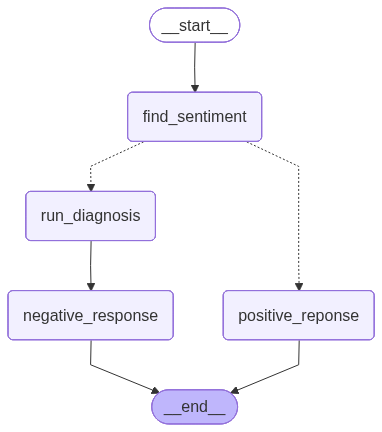

In [15]:
workflow

In [ ]:
initial_state = {
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

workflow.invoke(initial_state)